# Lab 7: Twitter Makes Us Sentimental

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
December 13th, 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Numpy version: ', np.__version__)
print('Tensorflow version: ', tf.__version__)

Numpy version:  1.24.3
Tensorflow version:  2.13.0


For this lab, we will be using the text-only [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140) from Kaggle. This dataset contains 1,600,000 tweets collected from the Twitter API. Below is an example of some of the rows in the dataset:

In [2]:
# Load the data
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Out of the provided columns, we will only need "sentiment" and "text" to classify sentiment in the tweets. Sentiment is the target variable. IDs, date information and the username of the individual who sent the tweet is irrelevant. The flag column refers to how the data was collected and is also irrelevant. Therefore, we will drop these columns.

Additionally, the dataset has 3 sentiment values:

 - 0: Negative
 - 2: Neutral
 - 4: Positive

We don't particularly find any value in classifying a tweet as neutral, so we will only move forward with positive and negative values of sentiment. Additionally, we will convert all of the 4s for positive sentiment to 1s to format the problem as a more classic binary classification problem.

In [3]:
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].replace(4, 1)

Additionally, with sequential networks, 1.6 million records will take a considerably long amount of time to train. Therefore, we will reduce the dataset size to 50,000, with a 50-50 class balance. We can always use more records later if we feel the need to.

In [4]:
# reduce size of dataset to 50,000 with equal number of positive and negative tweets
df_pos = df[df['sentiment'] == 1].sample(25000)
df_neg = df[df['sentiment'] == 0].sample(25000)
df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

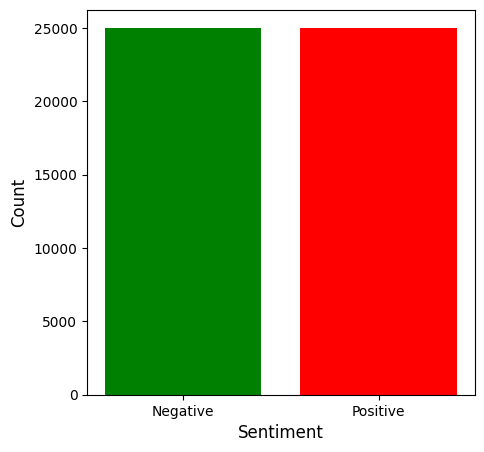

In [6]:
# plot the distribution of positive and negative sentiment

count = df['sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(count.index, count.values, color=['red', 'green'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(range(len(count.index)), ['Negative', 'Positive'])
plt.show()

### Evaluation Metric

Our evaluation metric of choice for this lab will be classification accuracy. 

Because of the balance we created by sampling postiive and negative tweets evenly, accuracy becomes more relevant because no class is overrpresented or underrepresented. We can evaluate a model with accuracy to see how it correctly classifies both classes. Additionally, there is no real penalty for misclassification. If we were operating with something like medical data, where false negatives would be extremely costly and false positives were less costly but still undesirable, then it would make sense to use something that measures precision and recall, like an FBeta score with a higher beta value. However, given the nature of our data, there is no mission-critical penalty for misclassification. We are simply interested in how well we can identify the sentiment of a tweet.

The goal of sentiment analysis is to correctly classify the sentiment of the records as accurately as possible; the business case is not to avoid misclassification at all costs like it might be with a medical scenario. Therefore, we feel that accuracy is the correct evaluation metric for this lab.

### Preprocessing

Now, we apply several preprocessing steps to each record:

 - Convert text to lowercase.
 - Replace any instances of URLs with a "URL" token.
 - Replace any instance of a user @'ing another user with a "USER" token.
 - Replace any instances of an eomji with its corresponding unicode representation.
 - Replace any contractions with the expanded contraction, i.e. turning "you're" into "you are".
 - Remove any non-alphanumeric characters.

In [7]:
import re
import contractions

def preprocessing(tweet):
    # Convert tweet to lower case
    tweet = tweet.lower()
    
    # Replace URLs with token
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet)
    
    # Replace user handles with token
    tweet = re.sub(r'@\w+', 'USER', tweet)

    # Replace emojis with token (basic example)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('EMOJI', tweet)
    
    # Replace contractions with their expansions
    tweet = contractions.fix(tweet)
    
    # Remove non-alphanumeric characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    
    return tweet


In [8]:
%%time
df['processed_text'] = df['text'].apply(preprocessing)

CPU times: total: 1.16 s
Wall time: 1.17 s


In [9]:
# Print out 10 samples of the original and processed text
for i in range(30,40):
    print('Original text: ', df['text'][i])
    print('Processed text: ', df['processed_text'][i])
    print()

Original text:  wowwwww, Adam Levine is in the Target ad 
Processed text:  woURL adam levine is in the target ad 

Original text:  Can't wait to see my bffs @ameliascolforo and @ohmanitsconnor 
Processed text:  cannot wait to see my bffs USER and USER 

Original text:  *sigh* what i wouldnt do to be at bamboozle right now. 
Processed text:  sigh what i would not do to be at bamboozle right now 

Original text:  I have a lot designing to do today. BRING ON THE CHALLENGE BABY! haha. 
Processed text:  i have a lot designing to do today bring on the challenge baby haha 

Original text:  LAX terminal very nice. It has been awhile since I've been here. Nice smooth flight frm ATL, except coughing/cracklespeak guy next to me 
Processed text:  lax terminal very nice it has been awhile since i have been here nice smooth flight frm atl except coughingcracklespeak guy next to me 

Original text:  Roll on Thursday 
Processed text:  roll on thursday 

Original text:  @jconpoet LOL! thanks 
Processed

##### TODO: add'l analysis on what preprocessing exposes? Inconsistent between different train/test splits, so could return to this before submission for add/' context

In [10]:
data_pos = df[df['sentiment'] == 1]['processed_text'].values
data_neg = df[df['sentiment'] == 0]['processed_text'].values

In [11]:
# create a word cloud for positive and negative tweets
from wordcloud import WordCloud

# Create positive and negative word lists for creating word clouds
data_pos = list(df[df['sentiment'] == 1]['processed_text'])
data_neg = list(df[df['sentiment'] == 0]['processed_text'])

def plot_wordcloud(data, color='black'):
    wordcloud = WordCloud(background_color=color, max_words=1000, width=1600, height=800, random_state=42, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

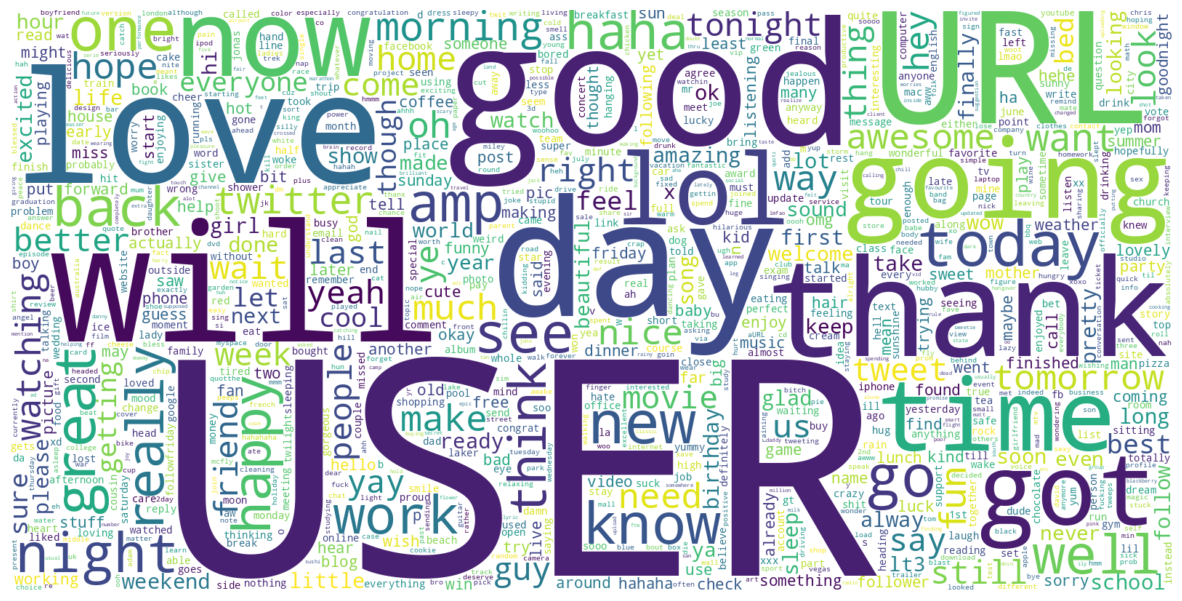

In [12]:
plot_wordcloud(data_pos, 'white')

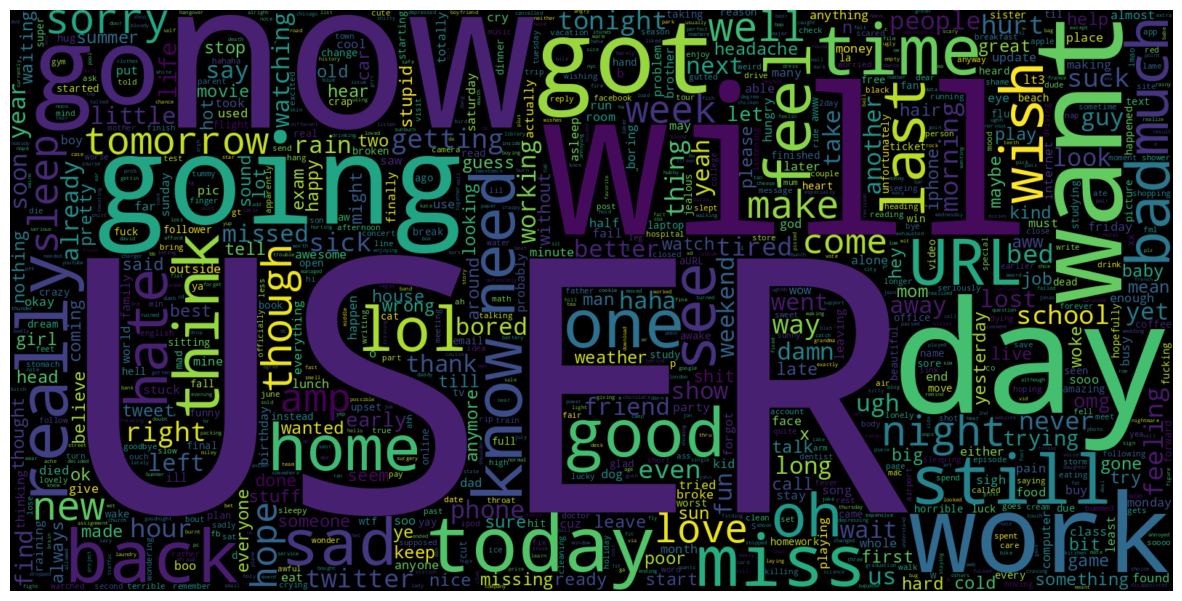

In [13]:
plot_wordcloud(data_neg)

In [14]:
# find the max length of a tweet

max_len = max([len(s.split()) for s in df['processed_text']])
print('Max length of a tweet: ', max_len)

Max length of a tweet:  36


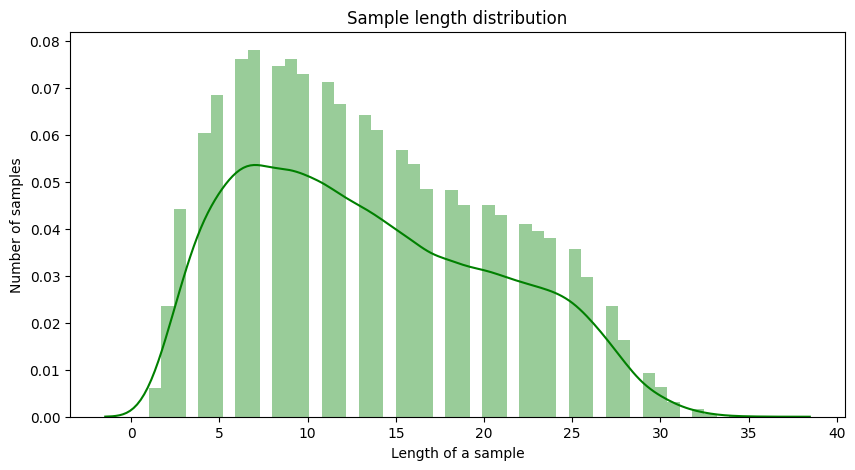

In [16]:
# plot the distribution of tweet lengths
import warnings
warnings.simplefilter('ignore', UserWarning)


plt.figure(figsize=(10, 5))
sns.distplot([len(s.split()) for s in df['processed_text']], color='green')
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

Now, we will set up our vocabulary by tokenizing the text and storing the tokens as sequences of integers.

We chose to set the max word length of a record to 36, because from the distribution above and snippet above, we can see that the longest tweets contain 36 tokens. This means that we will also pad all other sequences to be of length 36.

In [17]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['processed_text'].values
y = df['sentiment'].values

# Limit the sequence to 35 words
MAX_LEN = 36
VOCAB_SIZE = 60000

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', lower=False)
tokenizer.fit_on_texts(X)

# Save as sequences with integers instead of words
sequences = tokenizer.texts_to_sequences(X)

# Set vocab size to number of words if number of words < 60,000
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) if VOCAB_SIZE > len(word_index) else VOCAB_SIZE 
top_words = min((len(word_index), VOCAB_SIZE)) # Keep all of the top words
print('Found %s unique tokens. Distilled to %s.' % (len(word_index), top_words))

# Pad the sequences to be 36 words long
X = pad_sequences(sequences, maxlen=MAX_LEN)
y_ohe = keras.utils.to_categorical(y, 2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)

Found 42400 unique tokens. Distilled to 42400.
Shape of data tensor: (50000, 36)
Shape of label tensor: (50000, 2)
CPU times: total: 2.14 s
Wall time: 2.26 s


### Splitting the Data

Given the size of our dataset, we will opt for a simple train / test split of 80% / 20%. We feel comfortable training a model on 40,000 instances and then testing the model with 10,000 instances. If our dataset was smaller, say only 5,000 - 10,000 instances total, then we might want to perform some additional validation such as k-fold cross validation. However, for a dataset of this size, we believe we can train it as-is.

We will not perform any sort of stratified selection or synthetic sampling on the train / test split as the data we pulled already has an even class balance. Additionally, in a real-world scenario, it is highly unlikely that there would be a perfect 50% / 50% class balance on raw data taken from the internet, so we want our model to mirror a realistic implementation when we test it. 

X_train shape:  (40000, 36) Label shape:  (40000, 2)


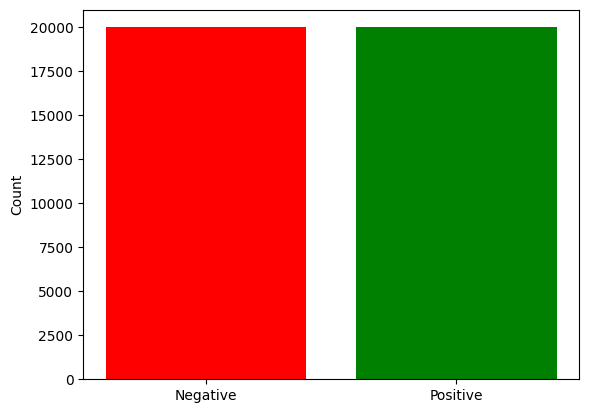

In [18]:
from sklearn.model_selection import train_test_split

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,test_size=0.2, random_state=42, stratify=y_ohe)

# print out some stats of the data
print('X_train shape: ', X_train.shape, 'Label shape: ', y_train.shape)
count = np.sum(y_train, axis=0)
plt.bar(range(2), count, color=['red', 'green'])
plt.xticks(range(2), ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

### Embedding

We decided to use glove's twitter embeddings because we are using a Twitter dataset.

In [19]:
%%time
EMBEDDING_SIZE = 100

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

FileNotFoundError: [Errno 2] No such file or directory: 'Embeddings/glove.twitter.27B.100d.txt'

In [20]:
from tensorflow.keras.layers import Embedding

# save the embedding layer as a variable
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

NameError: name 'embedding_matrix' is not defined

### Convolution

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(model.summary())

NameError: name 'embedding_layer' is not defined

In [102]:
histories = []
tmp = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
histories.append(tmp)

Epoch 1/3
313/313 [==============================] - 17s 35ms/step - loss: 0.6192 - accuracy: 0.6505 - val_loss: 0.5890 - val_accuracy: 0.6865
Epoch 2/3
313/313 [==============================] - 5s 16ms/step - loss: 0.5641 - accuracy: 0.7046 - val_loss: 0.5761 - val_accuracy: 0.6947
Epoch 3/3
313/313 [==============================] - 5s 16ms/step - loss: 0.5383 - accuracy: 0.7251 - val_loss: 0.5650 - val_accuracy: 0.7071
